In [ ]:
!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [ ]:
import seaborn as sns
# Set styles
sns.set(style="whitegrid")

# ------------------ 1. Basic Overview ------------------
print("📊 Dataset Shape:", df.shape)
print("\n📄 Columns:\n", df.columns.tolist())
print("\n🔍 Data Types:\n", df.dtypes)
print("\n🧾 Summary Statistics:\n", df.describe())
print("\n🧪 Missing Values:\n", df.isnull().sum())

📊 Dataset Shape: (284807, 31)

📄 Columns:
 ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

🔍 Data Types:
 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

🧾 Summary Statistics:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  


🎯 Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


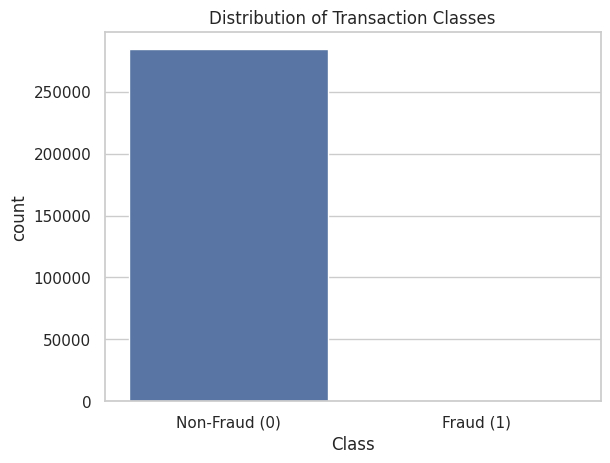

In [ ]:
# ------------------ 2. Class Distribution ------------------
print("\n🎯 Class Distribution:\n", df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Distribution of Transaction Classes")
plt.xticks([0,1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [ ]:
# Percentage of fraud cases
fraud_rate = df['Class'].mean() * 100
print(f"⚠️ Fraudulent transactions: {fraud_rate:.4f}%")

⚠️ Fraudulent transactions: 0.1727%


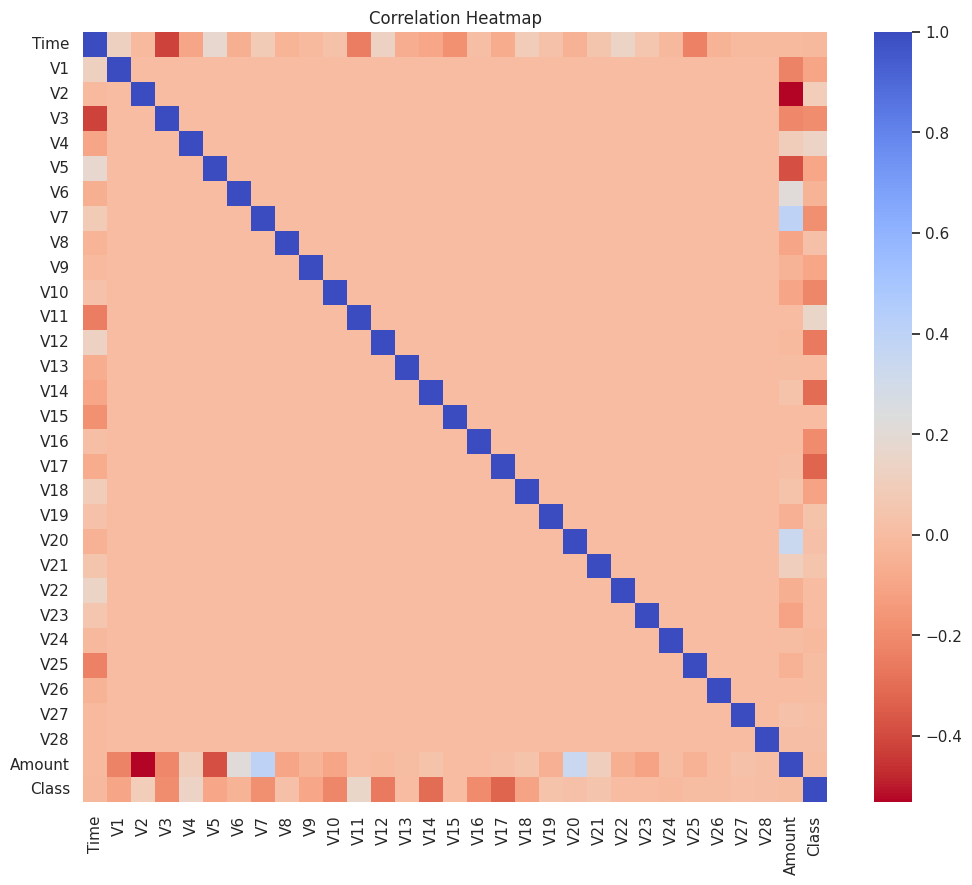


🔗 Features most correlated with Class:
Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64


In [ ]:
# ------------------ 3. Correlation Analysis ------------------
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Highly correlated with Class
print("\n🔗 Features most correlated with Class:")
print(corr['Class'].sort_values(ascending=False).head(10))


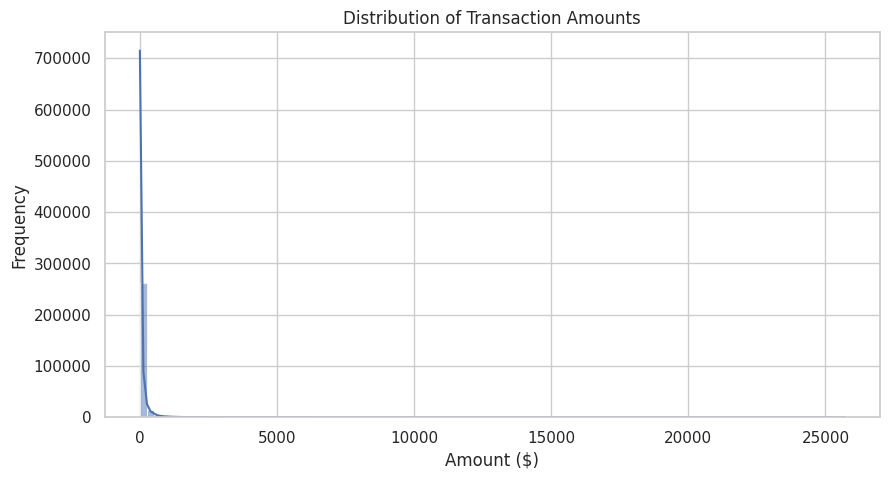

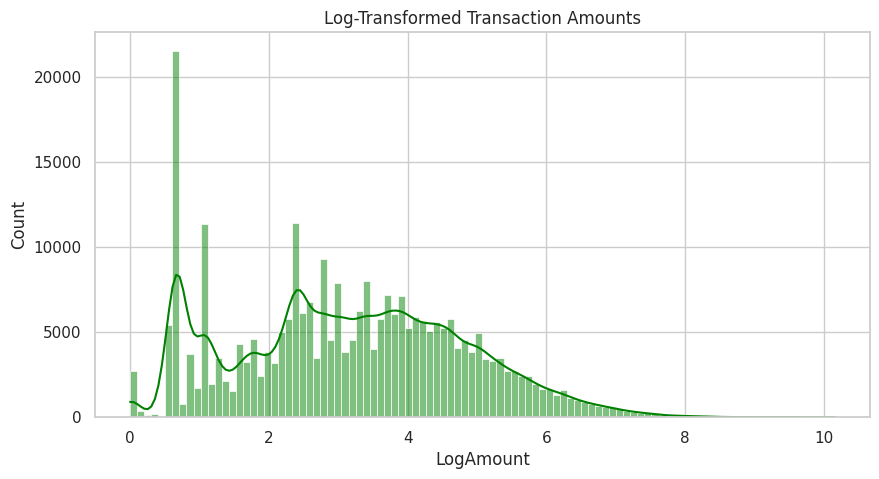

In [ ]:
# ------------------ 4. Time & Amount Analysis ------------------
# Histogram of Amount
plt.figure(figsize=(10, 5))
sns.histplot(df['Amount'], bins=100, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount ($)")
plt.ylabel("Frequency")
plt.show()

# Log scale to reduce skew
df['LogAmount'] = np.log1p(df['Amount'])

plt.figure(figsize=(10, 5))
sns.histplot(df['LogAmount'], bins=100, kde=True, color="green")
plt.title("Log-Transformed Transaction Amounts")
plt.show()

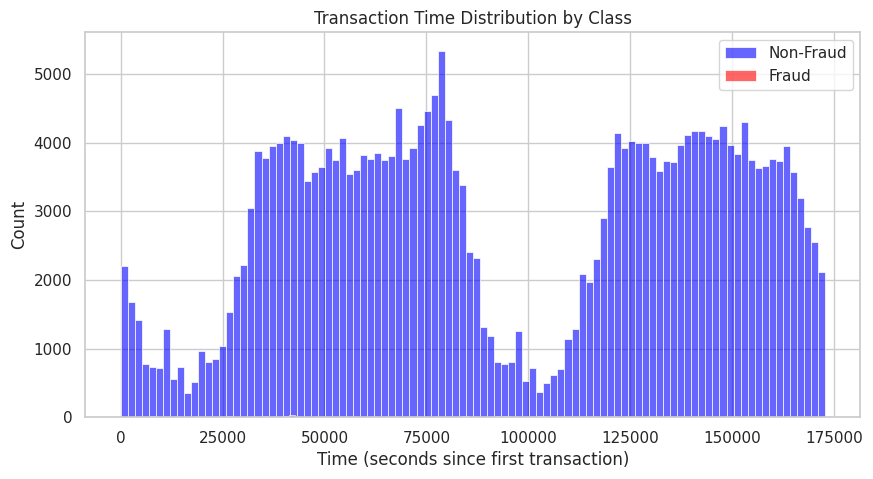

In [ ]:
# Time vs Class
plt.figure(figsize=(10, 5))
sns.histplot(df[df['Class'] == 0]['Time'], bins=100, color='blue', label='Non-Fraud', alpha=0.6)
sns.histplot(df[df['Class'] == 1]['Time'], bins=100, color='red', label='Fraud', alpha=0.6)
plt.legend()
plt.title("Transaction Time Distribution by Class")
plt.xlabel("Time (seconds since first transaction)")
plt.show()

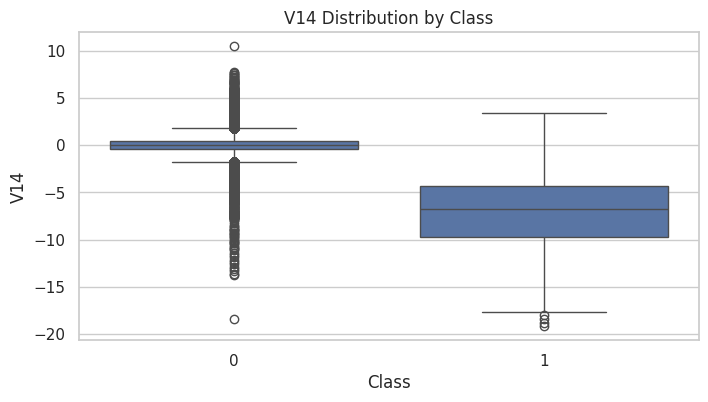

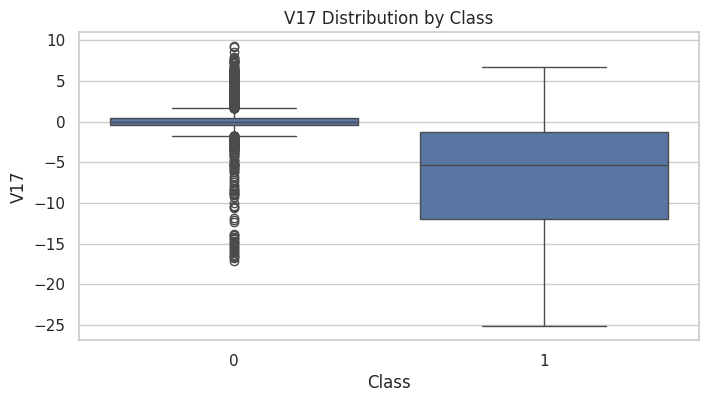

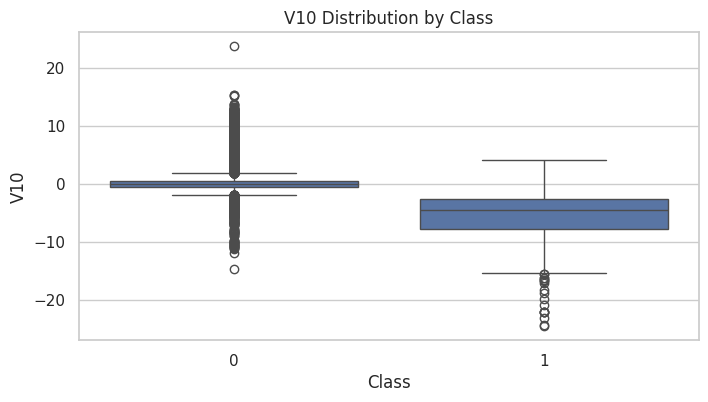

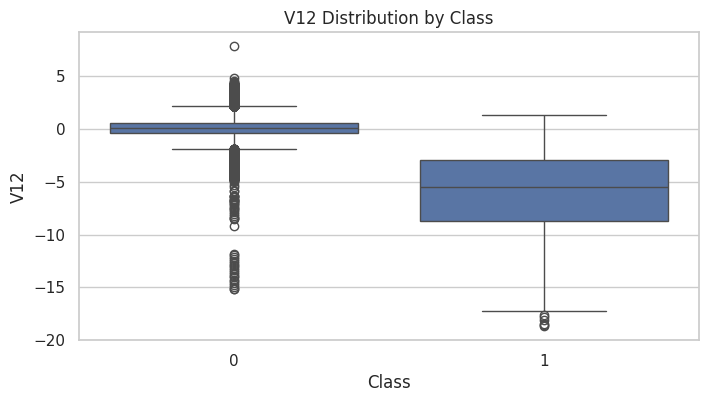

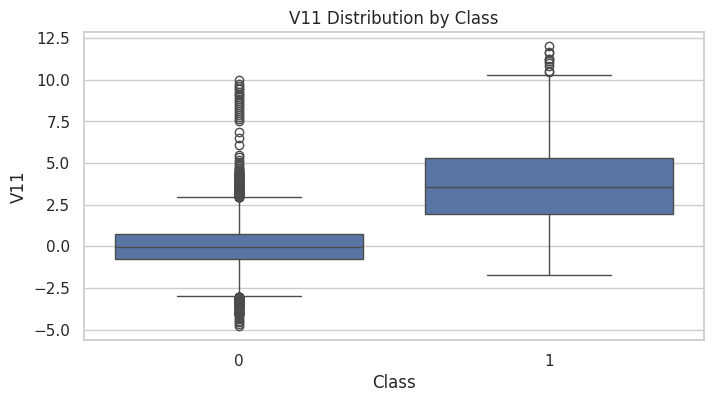

In [ ]:
# ------------------ 5. PCA Feature Distributions ------------------
# V1 to V28 are principal components
pca_features = [f'V{i}' for i in range(1, 29)]

# Boxplot for a few important features
important_features = ['V14', 'V17', 'V10', 'V12', 'V11']
for feature in important_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Class', y=feature, data=df)
    plt.title(f"{feature} Distribution by Class")
    plt.show()

In [ ]:
# Detect outliers using IQR for one feature
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)]
    return outliers

outliers_V14 = detect_outliers(df[df['Class'] == 1], 'V14')
print(f"\n🚨 Outliers in V14 among fraud cases: {len(outliers_V14)}")


🚨 Outliers in V14 among fraud cases: 4


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
df = shuffle(df, random_state=42)

X = df.drop("Class", axis=1)
y = df["Class"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split train data into 3 simulated clients
client_data = np.array_split(pd.concat([X_train, y_train], axis=1), 3)

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# ---------------------- 3. Each Client Trains Locally ---------------------- #
client_models = []
for i, client_df in enumerate(client_data):
    print(f"📦 Training client {i+1}")
    X_c = client_df.drop("Class", axis=1)
    y_c = client_df["Class"]

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_c_bal, y_c_bal = sm.fit_resample(X_c, y_c)

    # Local model training
    model = LogisticRegression(max_iter=1000, solver='liblinear')
    model.fit(X_c_bal, y_c_bal)
    client_models.append(model)

📦 Training client 1
📦 Training client 2
📦 Training client 3


In [ ]:
# ---------------------- 4. Federated Averaging (FedAvg) ---------------------- #
def average_weights(models):
    avg_coef = np.mean([model.coef_ for model in models], axis=0)
    avg_intercept = np.mean([model.intercept_ for model in models], axis=0)
    return avg_coef, avg_intercept

# Aggregate models
avg_coef, avg_intercept = average_weights(client_models)

# Create global model
global_model = LogisticRegression(max_iter=1000, solver='liblinear')
global_model.coef_ = avg_coef
global_model.intercept_ = avg_intercept
global_model.classes_ = np.array([0, 1])  # Needed to enable prediction

In [ ]:
# ---------------------- 5. Threshold Tuning on Central Test Set ---------------------- #
y_proba = global_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\n📌 Best threshold from federated model: {best_threshold:.4f}")

y_pred = (y_proba >= best_threshold).astype(int)


📌 Best threshold from federated model: 0.9996


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


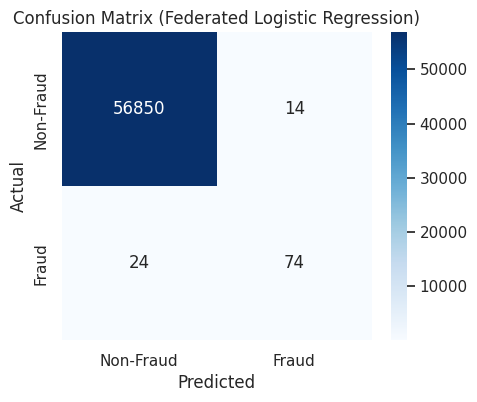


📄 Classification Report (Federated Logistic Regression):
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.84      0.76      0.80        98

    accuracy                           1.00     56962
   macro avg       0.92      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.title("Confusion Matrix (Federated Logistic Regression)")
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n📄 Classification Report (Federated Logistic Regression):")
print(classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"]))